In [2]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

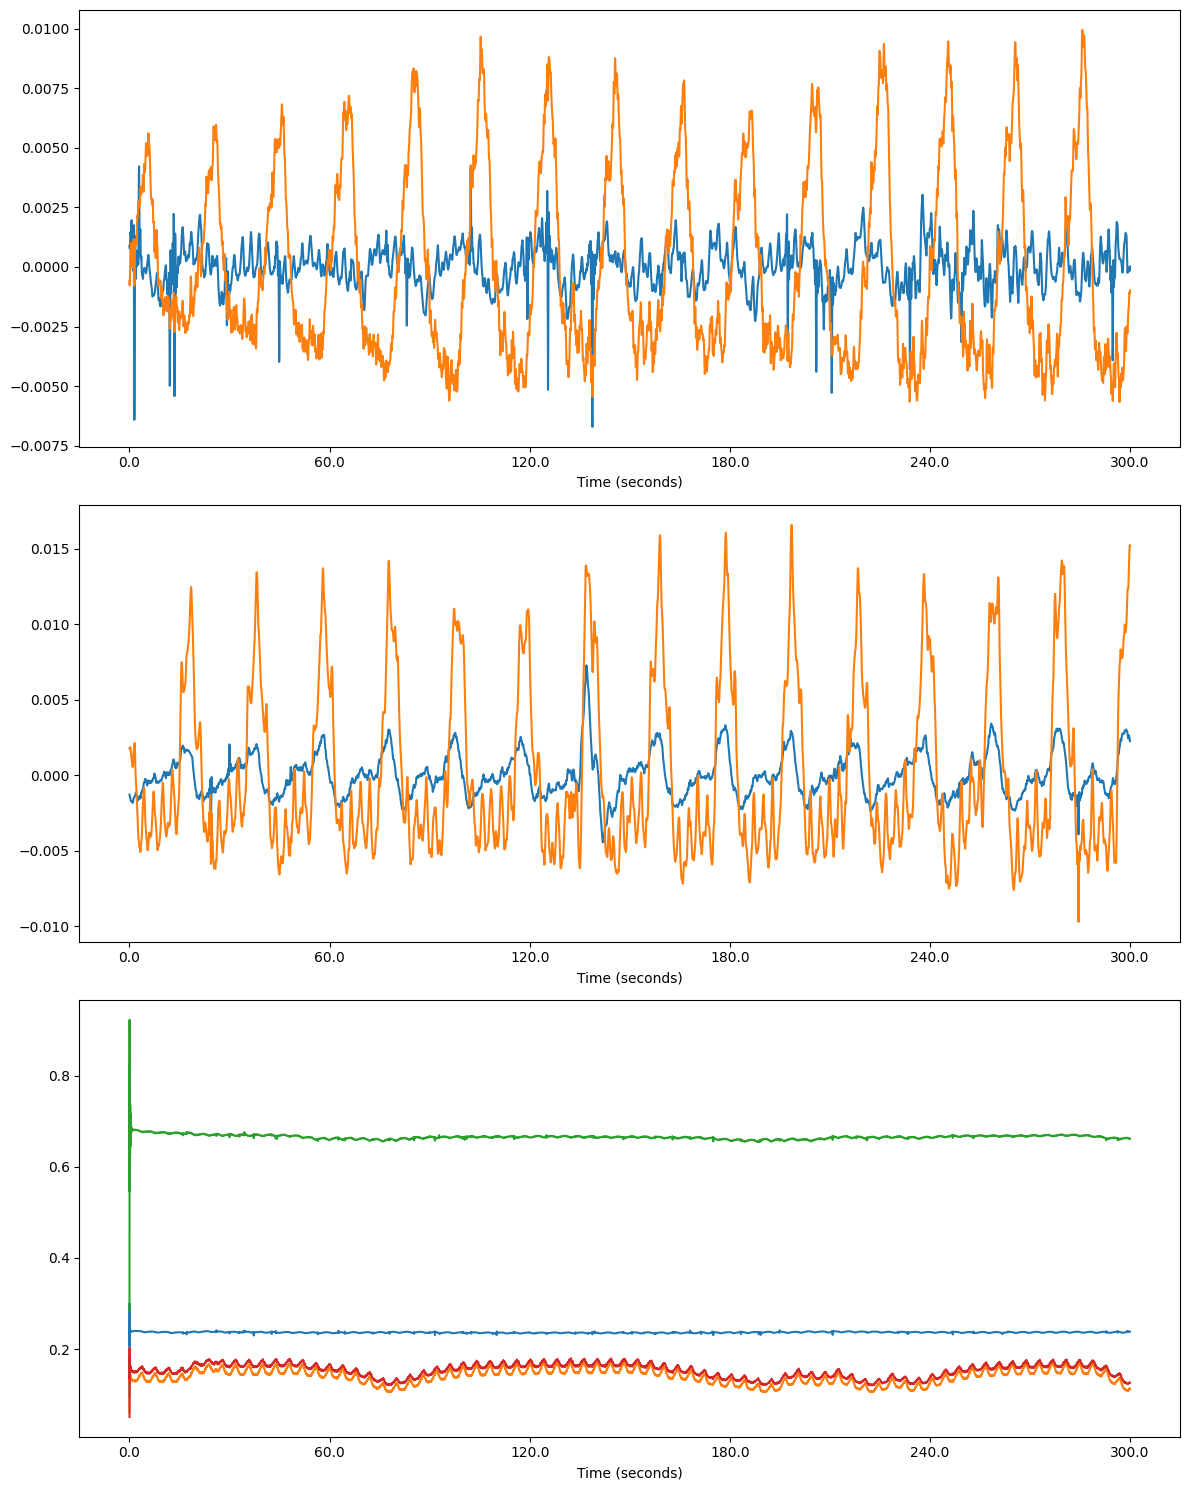

In [3]:
df1 = pd.read_csv('D:\\Codes\\CW_sheep\\CW_sheep\\05112022_sheep\\CW_extract_05-11-22.csv')
df2 = pd.read_csv('D:\\Codes\\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-11-22_P3.csv')
df3 = pd.read_csv('D:\\Codes\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))

def set_axis_labels(ax, length):
    time_ticks = np.linspace(0, 300, 6)  # [0, 60, 120, ...]
    normalized_ticks = np.linspace(0, 1, 6)  # [0, 0.2, 0.4, ...]
    ax.set_xticks(normalized_ticks)
    ax.set_xticklabels(time_ticks)
    ax.set_xlabel('Time (seconds)')


time_normalized = np.linspace(0, 1, len(df1))
for column in df1.columns:
    axes[0].plot(time_normalized, df1[column], label=column)
set_axis_labels(axes[0], len(df1))

time_normalized = np.linspace(0, 1, len(df2))
for column in df2.columns:
    axes[1].plot(time_normalized, df2[column], label=column)
set_axis_labels(axes[1], len(df2))

time_normalized = np.linspace(0, 1, len(df3))
for column in df3.columns:
    axes[2].plot(time_normalized, df3[column], label=column)
set_axis_labels(axes[2], len(df3))


plt.tight_layout()
plt.show()



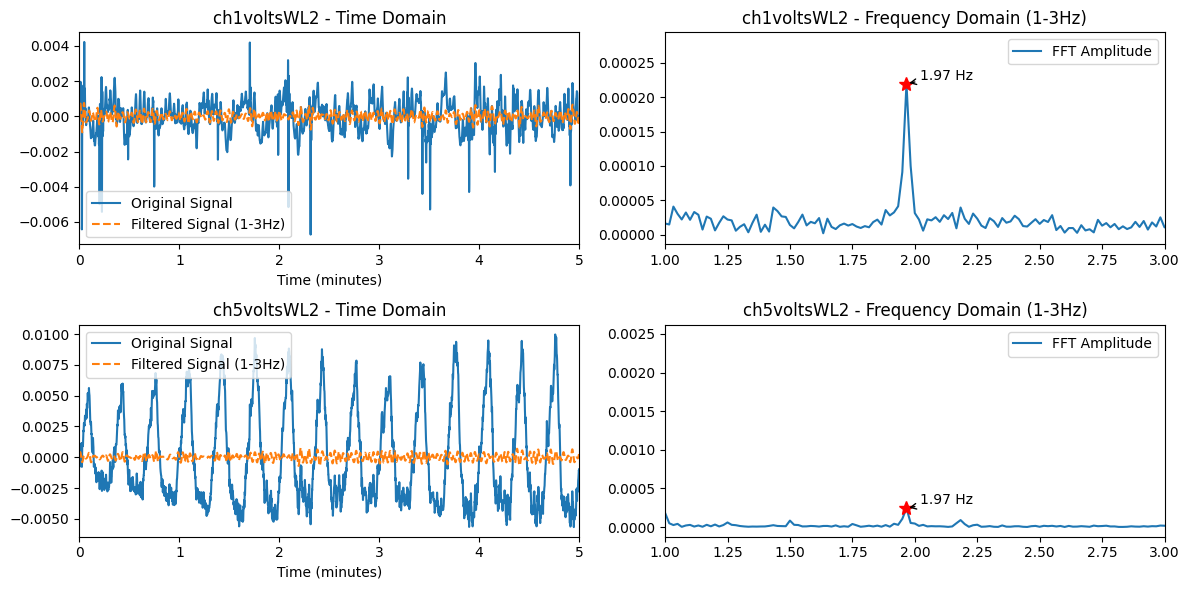

In [3]:

df1 = pd.read_csv('D:\\Codes\\CW_sheep\\CW_sheep\\05112022_sheep\\CW_extract_05-11-22.csv')

# 采样频率
fs = 80  # 采样频率设置为80Hz

fft_results = {}
for column in df1.columns:
    fft_results[column] = np.fft.fft(df1[column])

# 计算频率
freqs = np.fft.fftfreq(len(df1), 1/fs)

# 设计滤波器
def bandpass_filter(freq, lowcut=1.0, highcut=3.0):
    return (freq > lowcut) & (freq < highcut)

# 应用滤波器并逆FFT
filtered_fft = {}
for column in fft_results:
    filter_mask = bandpass_filter(freqs, 1.0, 3.0)
    filtered_fft[column] = np.copy(fft_results[column])
    filtered_fft[column][~filter_mask] = 0
    filtered_fft[column][~filter_mask] = 0  # 应用于负频率部分
reconstructed_signals = {column: np.fft.ifft(filtered_fft[column]).real for column in filtered_fft}

total_time_minutes = 5
time_vector = np.linspace(0, total_time_minutes, len(df1))

# 绘制时域图和频域图
n_columns = len(df1.columns)
fig, axes = plt.subplots(nrows=n_columns, ncols=2, figsize=(12, n_columns*3))

for i, column in enumerate(df1.columns):
    # 时域图 - 原始信号和滤波后的信号
    axes[i, 0].plot(time_vector, df1[column], label='Original Signal')
    axes[i, 0].plot(time_vector, reconstructed_signals[column], label='Filtered Signal (1-3Hz)', linestyle='--')
    axes[i, 0].set_xlim(0, total_time_minutes)
    axes[i, 0].set_xlabel('Time (minutes)')
    axes[i, 0].set_title(f'{column} - Time Domain')
    axes[i, 0].legend()

    # 频域图 - 原始信号
    fft_amplitude = np.abs(fft_results[column]) / len(df1)  # 归一化FFT幅值
    freqs_positive = freqs[:len(df1)//2]
    fft_amplitude_positive = fft_amplitude[:len(df1)//2]

    # 找出1-3Hz范围内的峰值频率
    mask_1_3hz = (freqs_positive >= 1) & (freqs_positive <= 3)
    peak_freq = freqs_positive[mask_1_3hz][np.argmax(fft_amplitude_positive[mask_1_3hz])]
    peak_amplitude = np.max(fft_amplitude_positive[mask_1_3hz])

    axes[i, 1].plot(freqs_positive, fft_amplitude_positive, label='FFT Amplitude')
    axes[i, 1].plot(peak_freq, peak_amplitude, 'r*', markersize=10)
    axes[i, 1].annotate(f'{peak_freq:.2f} Hz', xy=(peak_freq, peak_amplitude), xytext=(10, 3),
                     textcoords='offset points', arrowprops=dict(arrowstyle='->'))
    axes[i, 1].set_xlim(1, 3)  # 仅显示1-3Hz范围
    axes[i, 1].set_title(f'{column} - Frequency Domain (1-3Hz)')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


C:\Users\22877\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


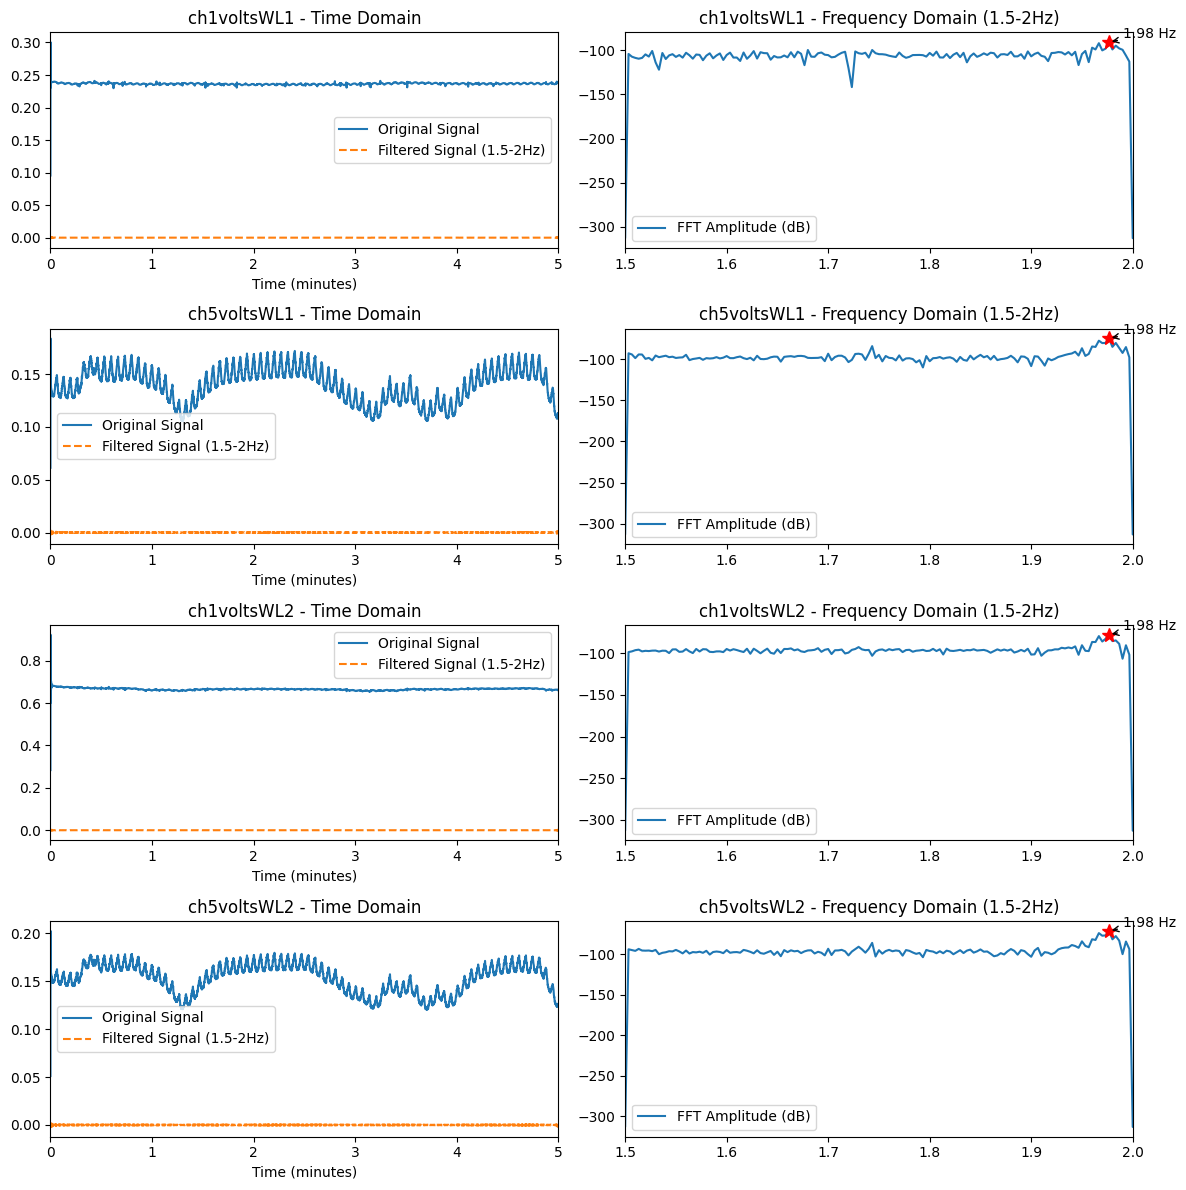

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 加载数据
df1 = pd.read_csv('D:\\Codes\\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv')
fs = 80  # 采样频率设置为80Hz

# 计算FFT和频率
fft_results = {}
for column in df1.columns:
    fft_results[column] = np.fft.fft(df1[column])
freqs = np.fft.fftfreq(len(df1), 1/fs)

# 设计带通滤波器
def bandpass_filter(freq, lowcut=1.5, highcut=2.0):
    return (freq > lowcut) & (freq < highcut)

# 应用滤波器并去除谐波
def remove_harmonics(freqs, fft_amplitude, harmonic_threshold=0.1):
    peaks, _ = find_peaks(fft_amplitude, height=harmonic_threshold)
    filtered_fft_amplitude = np.copy(fft_amplitude)
    for f in freqs[peaks]:
        harmonics = np.arange(2, int(freqs[-1] / f) + 1) * f
        for harmonic in harmonics:
            harmonic_idx = np.argmin(np.abs(freqs - harmonic))
            filtered_fft_amplitude[max(0, harmonic_idx-1):harmonic_idx+2] = 0
    return filtered_fft_amplitude

filtered_fft = {}
for column in fft_results:
    filter_mask = bandpass_filter(freqs, 1.5, 2.0)
    filtered_fft_amplitude = np.copy(fft_results[column])
    filtered_fft_amplitude[~filter_mask] = 0
    # 去除谐波
    filtered_fft_amplitude = remove_harmonics(freqs, filtered_fft_amplitude)
    filtered_fft[column] = filtered_fft_amplitude

# 逆FFT重构信号
reconstructed_signals = {column: np.fft.ifft(filtered_fft[column]).real for column in filtered_fft}

# 创建时间向量并绘制图表
total_time_minutes = 5
time_vector = np.linspace(0, total_time_minutes, len(df1))

n_columns = len(df1.columns)
fig, axes = plt.subplots(nrows=n_columns, ncols=2, figsize=(12, n_columns*3))
for i, column in enumerate(df1.columns):
    # 时域图
    axes[i, 0].plot(time_vector, df1[column], label='Original Signal')
    axes[i, 0].plot(time_vector, reconstructed_signals[column], label='Filtered Signal (1.5-2Hz)', linestyle='--')
    axes[i, 0].set_xlim(0, total_time_minutes)
    axes[i, 0].set_xlabel('Time (minutes)')
    axes[i, 0].set_title(f'{column} - Time Domain')
    axes[i, 0].legend()
    
    # 频域图，转换为dB尺度
    fft_amplitude = np.abs(filtered_fft[column]) / len(df1)
    fft_amplitude_db = 20 * np.log10(fft_amplitude + np.finfo(float).eps)  # 防止对数的0值
    freqs_positive = freqs[:len(df1)//2]
    fft_amplitude_positive_db = fft_amplitude_db[:len(df1)//2]
    axes[i, 1].plot(freqs_positive, fft_amplitude_positive_db, label='FFT Amplitude (dB)')
    if len(fft_amplitude_positive_db) > 0:
        peak_freq = freqs_positive[np.argmax(fft_amplitude_positive_db)]
        peak_amplitude_db = np.max(fft_amplitude_positive_db)
        axes[i, 1].plot(peak_freq, peak_amplitude_db, 'r*', markersize=10)
        axes[i, 1].annotate(f'{peak_freq:.2f} Hz', xy=(peak_freq, peak_amplitude_db), xytext=(10, 3), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
    axes[i, 1].set_xlim(1.5, 2)
    axes[i, 1].set_title(f'{column} - Frequency Domain (1.5-2Hz)')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


C:\Users\22877\AppData\Roaming\Python\Python311\site-packages\scipy\signal\_peak_finding.py:265: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)
C:\Users\22877\AppData\Local\Temp\ipykernel_14016\774109940.py:63: RuntimeWarning: divide by zero encountered in log10
  fft_amplitude_db = 20 * np.log10(fft_amplitude)


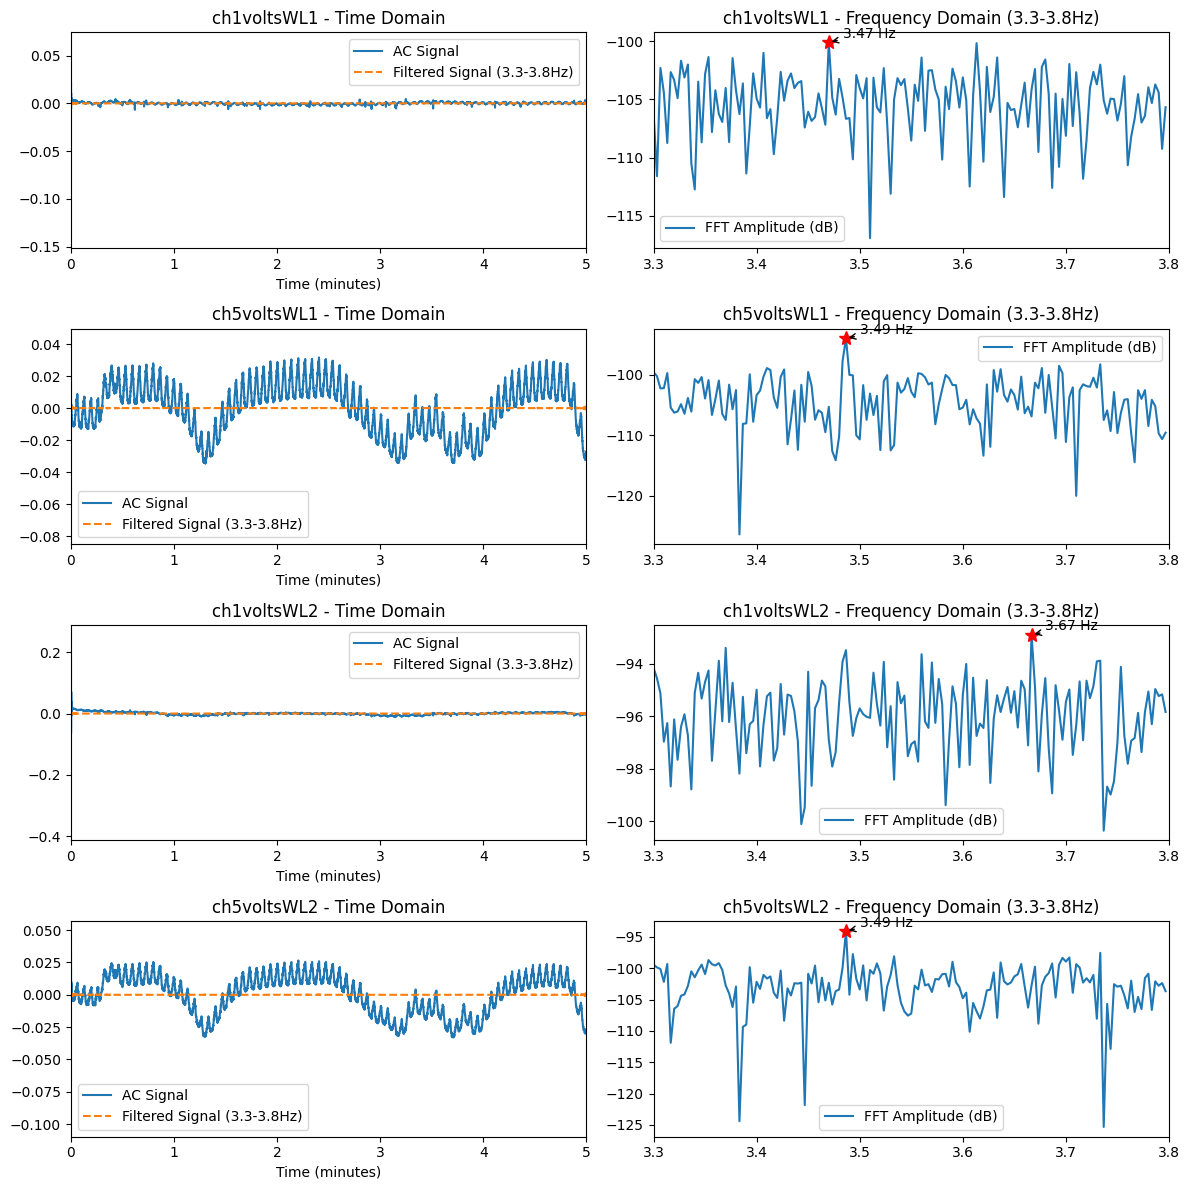

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 加载数据
df3_path = 'D:\\Codes\\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv'

df3 = pd.read_csv(df3_path)
fs = 80  # 采样频率

def bandpass_filter(freq, lowcut=3.3, highcut=3.8):
    return (freq > lowcut) & (freq < highcut)

def remove_harmonics(freqs, fft_amplitude, harmonic_threshold=0.1):
    peaks, _ = find_peaks(fft_amplitude, height=harmonic_threshold)
    filtered_fft_amplitude = np.copy(fft_amplitude)
    for f in freqs[peaks]:
        harmonics = np.arange(2, int(freqs[-1] / f) + 1) * f
        for harmonic in harmonics:
            harmonic_idx = np.argmin(np.abs(freqs - harmonic))
            filtered_fft_amplitude[max(0, harmonic_idx-1):harmonic_idx+2] = 0
    return filtered_fft_amplitude

# 频率
freqs = np.fft.fftfreq(len(df3), 1/fs)

# 单独计算并去除每列的DC分量
df3_ac = df3.copy()
for column in df3.columns:
    dc_component = df3[column][100:].mean()
    df3_ac[column] = df3[column] - dc_component

# 应用带通滤波器并去除谐波
filtered_fft = {}
for column in df3_ac.columns:
    fft_result = np.fft.fft(df3_ac[column])
    filter_mask = bandpass_filter(freqs, 3.3, 3.8)
    filtered_fft_amplitude = np.copy(fft_result)
    filtered_fft_amplitude[~filter_mask] = 0
    filtered_fft_amplitude = remove_harmonics(freqs, filtered_fft_amplitude)
    filtered_fft[column] = filtered_fft_amplitude

# 逆FFT重构信号
reconstructed_signals = {column: np.fft.ifft(filtered_fft[column]).real for column in filtered_fft}

# 绘制时域图和频域图
total_time_minutes = len(df3_ac) / fs / 60
time_vector = np.linspace(0, total_time_minutes, len(df3_ac))
n_columns = len(df3_ac.columns)
fig, axes = plt.subplots(nrows=n_columns, ncols=2, figsize=(12, n_columns*3))
for i, column in enumerate(df3_ac.columns):
    # 时域图
    axes[i, 0].plot(time_vector, df3_ac[column], label='AC Signal')
    axes[i, 0].plot(time_vector, reconstructed_signals[column], label='Filtered Signal (3.3-3.8Hz)', linestyle='--')
    axes[i, 0].set_xlim(0, total_time_minutes)
    axes[i, 0].set_xlabel('Time (minutes)')
    axes[i, 0].set_title(f'{column} - Time Domain')
    axes[i, 0].legend()
    
    # 频域图，转换为dB尺度
    fft_amplitude = np.abs(filtered_fft[column]) / len(df3_ac)
    fft_amplitude_db = 20 * np.log10(fft_amplitude)
    freqs_positive = freqs[:len(df3_ac)//2]
    fft_amplitude_positive_db = fft_amplitude_db[:len(df3_ac)//2]
    axes[i, 1].plot(freqs_positive, fft_amplitude_positive_db, label='FFT Amplitude (dB)')
    if len(fft_amplitude_positive_db) > 0:  # 确保有数据可绘制
        peak_freq = freqs_positive[np.argmax(fft_amplitude_positive_db)]
        peak_amplitude_db = np.max(fft_amplitude_positive_db)
        axes[i, 1].plot(peak_freq, peak_amplitude_db, 'r*', markersize=10)
        axes[i, 1].annotate(f'{peak_freq:.2f} Hz', xy=(peak_freq, peak_amplitude_db), xytext=(10, 3), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
    axes[i, 1].set_xlim(3.3, 3.8)
    axes[i, 1].set_title(f'{column} - Frequency Domain (3.3-3.8Hz)')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [10]:

df2 = pd.read_csv('D:\\Codes\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv')

# 定义采样频率和周期
f = 1.5  # 假设频率为1.5Hz
T = 1 / f  # 计算周期
fs = 80  # 根据您的数据实际情况来设置采样频率
samples_per_period = int(T * fs)  # 每个周期的样本数

# 初始化一个字典来存储每列所有周期平均值的列表
all_periods_avgs = {column: [] for column in df2.columns}

# 遍历每一列，计算每个周期的平均值
for column in df2.columns:
    # 计算周期平均值
    for i in range(0, len(df2[column]), samples_per_period):
        period_data = df2[column].iloc[i:i + samples_per_period]
        if len(period_data) == samples_per_period:  # 确保周期完整
            period_avg = period_data.mean()
            all_periods_avgs[column].append(period_avg)

# 计算并打印每列所有周期平均值的整体平均值
for column in all_periods_avgs:
    overall_avg = np.mean(all_periods_avgs[column])
    print(f"{column} - Overall Average Across Periods: {overall_avg}")


ch1voltsWL1 - Overall Average Across Periods: 0.23649698163299385
ch5voltsWL1 - Overall Average Across Periods: 0.1403378339873101
ch1voltsWL2 - Overall Average Across Periods: 0.6655290536817499
ch5voltsWL2 - Overall Average Across Periods: 0.15324069723660044


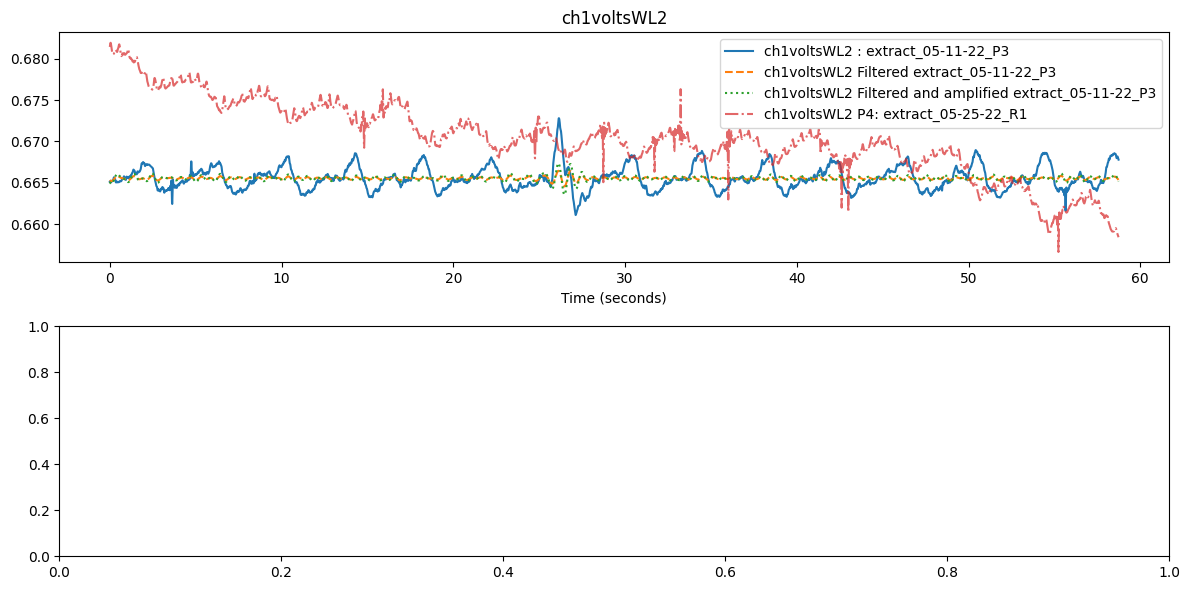

In [13]:

# 读取数据
df1 = pd.read_csv('D:\\Codes\\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-11-22_P3.csv')
df2 = pd.read_csv('D:\\Codes\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv')

# 提取感兴趣的列
columns_of_interest = ['ch1voltsWL2', 'ch5voltsWL2']
df2 = df2[columns_of_interest]

# 排除df1中前1000个数据点
start_index = 100
df1 = df1.iloc[start_index:]

df1_rows = len(df1)

# 截断df2以匹配df1的行数
df2 = df2.iloc[start_index:start_index+df1_rows]

# 采样频率
fs = 80  # 采样频率设置为80Hz

time_axis = np.arange(df1_rows) / fs

# FFT变换
fft_results = {}
for column in df1.columns:
    fft_results[column] = np.fft.fft(df1[column])

# 设计滤波器
def bandpass_filter(freq, lowcut=1.0, highcut=2.0):
    return (freq > lowcut) & (freq < highcut)

# 应用滤波器
filtered_fft = {}
freqs = np.fft.fftfreq(len(df1), 1/fs)
for column in fft_results:
    filter_mask = bandpass_filter(freqs, 1.5 - 0.5, 1.5 + 0.5)
    filtered_fft[column] = np.copy(fft_results[column])
    filtered_fft[column][~filter_mask] = 0

# 逆FFT变换
reconstructed_signals = {column: np.fft.ifft(filtered_fft[column]).real for column in filtered_fft}

# 扩大滤波后的信号
amplified_signals = {column: signal * 2 for column, signal in reconstructed_signals.items()}  # 扩大2倍

# DC部分的值
dc_values = {
    'ch1voltsWL2': 0.6655290536817499,
    'ch5voltsWL2': 0.15324069723660044
}

for column in df1.columns:
    if column in dc_values:
        df1[column] += dc_values[column]
        reconstructed_signals[column] += dc_values[column]
        amplified_signals[column] += dc_values[column]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

for i, column in enumerate(columns_of_interest):
    if column in df1.columns:
        # 绘制 df1 的处理后结果
        axes[i].plot(time_axis, df1[column], label=f'{column} : extract_05-11-22_P3')
        axes[i].plot(time_axis, reconstructed_signals[column], label=f'{column} Filtered extract_05-11-22_P3', linestyle='--')
        axes[i].plot(time_axis, amplified_signals[column], label=f'{column} Filtered and amplified extract_05-11-22_P3', linestyle=':')

        # 绘制 df2 的原始数据
        axes[i].plot(time_axis, df2[column], label=f'{column} P4: extract_05-25-22_R1', linestyle='-.', alpha=0.7)

        axes[i].set_title(column)
        axes[i].set_xlabel('Time (seconds)')
        axes[i].legend()

plt.tight_layout()
plt.show()


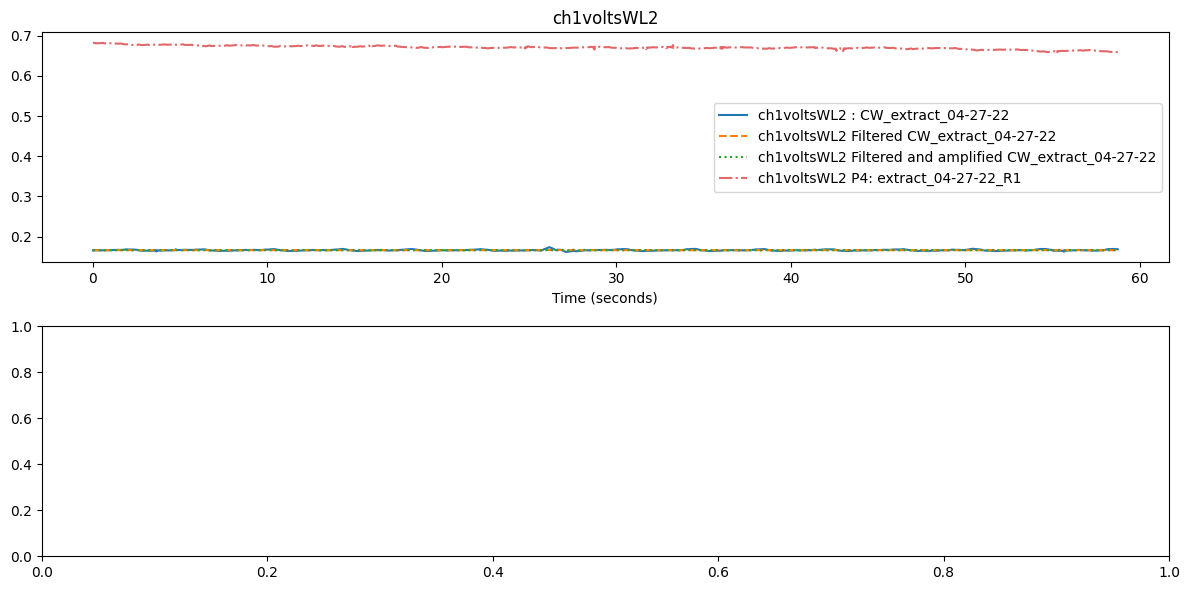

In [9]:

# 读取数据
df1 = pd.read_csv('D:\\Codes\\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-11-22_P3.csv')
df2 = pd.read_csv('D:\\Codes\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv')

# 提取感兴趣的列
columns_of_interest = ['ch1voltsWL2', 'ch5voltsWL2']
df2 = df2[columns_of_interest]

# 排除df1中前1000个数据点
start_index = 100
df1 = df1.iloc[start_index:]

df1_rows = len(df1)

# 截断df2以匹配df1的行数
df2 = df2.iloc[start_index:start_index+df1_rows]

# 采样频率
fs = 80  # 采样频率设置为80Hz

time_axis = np.arange(df1_rows) / fs

# FFT变换
fft_results = {}
for column in df1.columns:
    fft_results[column] = np.fft.fft(df1[column])

# 设计滤波器
def bandpass_filter(freq, lowcut=1.0, highcut=2.0):
    return (freq > lowcut) & (freq < highcut)

# 应用滤波器
filtered_fft = {}
freqs = np.fft.fftfreq(len(df1), 1/fs)
for column in fft_results:
    filter_mask = bandpass_filter(freqs, 1.5 - 0.25, 1.5 + 0.5)
    filtered_fft[column] = np.copy(fft_results[column])
    filtered_fft[column][~filter_mask] = 0

# 逆FFT变换
reconstructed_signals = {column: np.fft.ifft(filtered_fft[column]).real for column in filtered_fft}

# 扩大滤波后的信号
amplified_signals = {column: signal * 2 for column, signal in reconstructed_signals.items()}  # 扩大2倍

# DC部分的值
dc_values = {
    'ch1voltsWL2': 0.16658099127567208,
    'ch5voltsWL2': 0.11014730405743865
}

# 加上DC部分
for column in df1.columns:
    if column in dc_values:
        df1[column] += dc_values[column]
        reconstructed_signals[column] += dc_values[column]
        amplified_signals[column] += dc_values[column]

# 绘制图表
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

for i, column in enumerate(columns_of_interest):
    if column in df1.columns:
        # 绘制 df1 的处理后结果
        axes[i].plot(time_axis, df1[column], label=f'{column} : CW_extract_04-27-22')
        axes[i].plot(time_axis, reconstructed_signals[column], label=f'{column} Filtered CW_extract_04-27-22', linestyle='--')
        axes[i].plot(time_axis, amplified_signals[column], label=f'{column} Filtered and amplified CW_extract_04-27-22', linestyle=':')

        # 绘制 df2 的原始数据
        axes[i].plot(time_axis, df2[column], label=f'{column} P4: extract_04-27-22_R1', linestyle='-.', alpha=0.7)

        axes[i].set_title(column)
        axes[i].set_xlabel('Time (seconds)')
        axes[i].legend()

plt.tight_layout()
plt.show()


In [5]:
# 735nm L 
path4 = 'D:\\Codes\\CW_sheep\\CW_sheep\\4layer_pathlength_735nm_1cmSD_120Mphotons.mat'

data4 = scipy.io.loadmat(path4)

key4 = list(data4.keys())[-1]  
df4 = pd.DataFrame(data4[key4])

df4 = df4.rename(columns={
    0: 'L1',
    1: 'L2',
    2: 'L3',
    3: 'L4'
})
print(df4)



#850nm L
path5 = 'D:\\Codes\\CW_sheep\\CW_sheep\\4layer_pathlength_850nm_1cmSD_120Mphotons.mat'

data5 = scipy.io.loadmat(path5)

key5 = list(data5.keys())[-1]  
df5 = pd.DataFrame(data5[key5])

df5 = df5.rename(columns={
    0: 'L1',
    1: 'L2',
    2: 'L3',
    3: 'L4'
})
print(df5)


               L1          L2   L3   L4
0       54.753288    0.000000  0.0  0.0
1       78.021431    0.000000  0.0  0.0
2       90.904373    0.000000  0.0  0.0
3       64.026131    0.000000  0.0  0.0
4      100.246094    0.000000  0.0  0.0
...           ...         ...  ...  ...
76983  791.668518  105.075806  0.0  0.0
76984  206.021210    0.000000  0.0  0.0
76985  846.656433  310.908875  0.0  0.0
76986  158.841934    0.000000  0.0  0.0
76987  243.857040    0.000000  0.0  0.0

[76988 rows x 4 columns]
               L1          L2         L3          L4
0       76.847389    0.000000   0.000000    0.000000
1       93.969093    0.000000   0.000000    0.000000
2       70.635590    0.000000   0.000000    0.000000
3       54.342648    0.000000   0.000000    0.000000
4      101.691292    0.000000   0.000000    0.000000
...           ...         ...        ...         ...
83859  107.901711    0.000000   0.000000    0.000000
83860  150.270004    0.000000   0.000000    0.000000
83861  555.481323

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# 读取 CSV 文件
df2 = pd.read_csv('D:\\Codes\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv')
df2 = df2.apply(pd.to_numeric, errors='coerce')

# 定义采样频率和周期
f = 1.5  # 假设频率为1.5Hz
T = 1 / f  # 计算周期
fs = 80  # 采样频率

# 初始化deltas数组
deltas = np.linspace(0, 1, 100)

# 为WL1和WL2定义参数
params = {
    'WL1': {'ua1': 0.0085, 'constant': 77000, 'L1_values': df4['L1'].values * np.exp(-0.0085 * df4['L1'].values)},
    'WL2': {'ua1': 0.0088, 'constant': 83900, 'L1_values': df5['L1'].values * np.exp(-0.0088 * df5['L1'].values)}
}

# 创建一个空的DataFrame来存储反FFT结果
df_reconstructed = pd.DataFrame(index=df2.index)

# 遍历每一列进行FFT和反FFT处理
for column in df2.columns:
    # 获取列数据，并转换为 numpy 数组
    original_signal = df2[column].values
    signal = df2[column].values
    n = len(signal)

    # 应用 FFT
    yf = fft(signal)

    # 生成对应的频率值
    xf = np.linspace(0.0, fs/2, n//2)

    # 找到最接近1.5Hz的频率索引
    target_freq = 1.5
    index = np.where((xf >= target_freq - 0.5) & (xf <= target_freq + 0.5))[0]
    
    # 创建一个只含目标频率成分的信号
    yf_filtered = np.zeros_like(yf)
    yf_filtered[index] = yf[index]
    yf_filtered[-index] = yf[-index]  # 对称的负频率部分也要赋值

    # 应用逆FFT来重建信号
    reconstructed_signal = ifft(yf_filtered).real  # 取实部

    # 将重建的信号添加到新的DataFrame中
    df_reconstructed[column] = reconstructed_signal

    # 计算每个周期的最大值和最小值
    samples_per_period = int(T * fs)  # 每个周期的样本数
    num_periods = len(reconstructed_signal) // samples_per_period
    split_data = np.array_split(reconstructed_signal, num_periods)
    
    max_values = [np.max(period_data) for period_data in split_data if len(period_data) == samples_per_period]
    min_values = [np.min(period_data) for period_data in split_data if len(period_data) == samples_per_period]
    
    # 计算最大值和最小值的平均值
    avg_max = np.mean(max_values)
    avg_min = np.mean(min_values)
    
    # 计算所有周期平均值的整体平均值
    num_periods_original = len(original_signal) // samples_per_period
    split_data_original = np.array_split(original_signal, num_periods_original)
    overall_avg = np.mean([np.mean(period_data) for period_data in split_data_original if len(period_data) == samples_per_period])

    # 计算平均最大值和最小值之间的差值（avg_diff）
    avg_diff = avg_max - avg_min
    
    # 根据列选择参数
    if 'WL1' in column:
        ua1 = params['WL1']['ua1']
        constant = params['WL1']['constant']
        L1_values = params['WL1']['L1_values']
    else:
        ua1 = params['WL2']['ua1']
        constant = params['WL2']['constant']
        L1_values = params['WL2']['L1_values']

    # 计算方程左边的值
    left_side = -np.log10((overall_avg+avg_max)/ (overall_avg - avg_min))

    # 找到最接近的delta值
    right_sides = np.exp(np.sum(deltas[:, np.newaxis] * ua1 * L1_values, axis=1) / constant)
    index = np.argmin(np.abs(right_sides - left_side))
    best_delta = deltas[index]
    
    # 输出结果
    print(f"For column {column}:")
    print(f"Estimated Period: {samples_per_period} samples")
    print(f"Average Max per Period: {avg_max}")
    print(f"Average Min per Period: {avg_min}")
    print(f"Average Max-Min Difference per Period: {avg_diff}")
    print(f"Overall Average Across Periods: {overall_avg}")
    print(f"Best Delta corresponding to ratio: {best_delta}\n")

       


For column ch1voltsWL1:
Estimated Period: 53 samples
Average Max per Period: 0.00014511440889227584
Average Min per Period: -0.00014660407401742673
Average Max-Min Difference per Period: 0.00029171848290970257
Overall Average Across Periods: 0.23639198483166854
Best Delta corresponding to ratio: 0.0

For column ch5voltsWL1:
Estimated Period: 53 samples
Average Max per Period: 0.0007336848719668153
Average Min per Period: -0.0007439185292536779
Average Max-Min Difference per Period: 0.001477603401220493
Overall Average Across Periods: 0.14001642480577137
Best Delta corresponding to ratio: 0.0

For column ch1voltsWL2:
Estimated Period: 53 samples
Average Max per Period: 0.0004968151927361409
Average Min per Period: -0.0005006421883062927
Average Max-Min Difference per Period: 0.0009974573810424335
Overall Average Across Periods: 0.664612549944506
Best Delta corresponding to ratio: 0.0

For column ch5voltsWL2:
Estimated Period: 53 samples
Average Max per Period: 0.0009452434086861122
Aver

In [7]:
# 读取 CSV 文件
df2 = pd.read_csv('D:\\Codes\CW_sheep\\CW_sheep\\05112022_sheep\\extract_05-25-22_R1.csv')
df2 = df2.apply(pd.to_numeric, errors='coerce')



# 定义采样频率和周期
f = 1.5  # 假设频率为1.5Hz
T = 1 / f  # 计算周期
fs = 80  # 采样频率

# 为WL1和WL2定义参数
params = {
    'WL1': {'ua1': 0.0085, 'constant': 77000, 'L1_values': df4['L1'].values * np.exp(-0.0085 * df4['L1'].values)},
    'WL2': {'ua1': 0.0088, 'constant': 83900, 'L1_values': df5['L1'].values * np.exp(-0.0088 * df5['L1'].values)}
}

# 初始化deltas数组
deltas = np.linspace(0, 1, 100)

# 创建一个空的DataFrame来存储反FFT结果
df_reconstructed = pd.DataFrame(index=df2.index)

# 初始化用于存储不同波长下特定通道的值的字典
channel_specific_values = {
    'Ch1': {'WL1': None, 'WL2': None}
}

for column in df2.columns:
    # 获取原始信号
    original_signal = df2[column].values
    n = len(original_signal)

    # 应用 FFT
    yf = fft(original_signal)

    # 生成对应的频率值
    xf = np.linspace(0.0, fs/2, n//2)

    # 找到最接近1.5Hz的频率索引
    target_freq = 1.5
    index = np.where((xf >= target_freq - 0.5) & (xf <= target_freq + 0.5))[0]
    
    # 创建一个只含目标频率成分的信号
    yf_filtered = np.zeros_like(yf)
    yf_filtered[index] = yf[index]
    yf_filtered[-index] = yf[-index]  # 对称的负频率部分也要赋值

    # 应用逆FFT来重建信号
    reconstructed_signal = ifft(yf_filtered).real  # 取实部

    # 将重建的信号添加到新的DataFrame中
    df_reconstructed[column] = reconstructed_signal

    # 计算重建信号的每个周期的最大值和最小值
    samples_per_period = int(T * fs)  # 每个周期的样本数
    num_periods_reconstructed = len(reconstructed_signal) // samples_per_period
    split_data_reconstructed = np.array_split(reconstructed_signal, num_periods_reconstructed)
    
    max_values = [np.max(period_data) for period_data in split_data_reconstructed if len(period_data) == samples_per_period]
    min_values = [np.min(period_data) for period_data in split_data_reconstructed if len(period_data) == samples_per_period]
    
    # 计算最大值和最小值的平均值
    avg_max = np.mean(max_values)
    avg_min = np.mean(min_values)

    # 划分原始信号为周期并计算每个周期的平均值
    num_periods_original = len(original_signal) // samples_per_period
    split_data_original = np.array_split(original_signal, num_periods_original)
    overall_avg = np.mean([np.mean(period_data) for period_data in split_data_original if len(period_data) == samples_per_period])

    # 计算方程左边的值
    left_side_value = -np.log10((overall_avg + avg_max) / (overall_avg - avg_min))
    print(f"For column {column}, -log10((overall_avg + avg_max) / (overall_avg - avg_min)): {left_side_value}")

    # 存储特定通道的值
    if 'Ch1' in column:
        wl_key = 'WL1' if 'WL1' in column else 'WL2'
        channel_specific_values['CH1'][wl_key] = left_side_value

    # 根据列选择参数
    if 'WL1' in column:
        ua1 = params['WL1']['ua1']
        constant = params['WL1']['constant']
        L1_values = params['WL1']['L1_values']
    else:
        ua1 = params['WL2']['ua1']
        constant = params['WL2']['constant']
        L1_values = params['WL2']['L1_values']

    # 找到最接近的delta值
    right_sides = np.exp(np.sum(deltas[:, np.newaxis] * ua1 * L1_values, axis=1) / constant)
    index = np.argmin(np.abs(right_sides - left_side_value))
    best_delta = deltas[index]
    
    print(f"For column {column}:")
    print(f"Estimated Period: {samples_per_period} samples")
    print(f"Average Max per Period: {avg_max}")
    print(f"Average Min per Period: {avg_min}")
    print(f"Best Delta corresponding to ratio: {best_delta}\n")

# 打印CH1通道下不同WL的值的比值
wl1_value = channel_specific_values['Ch1']['WL1']
wl2_value = channel_specific_values['Ch1']['WL2']
if wl1_value is not None and wl2_value is not None:
    ratio = wl1_value / wl2_value
    print(f"Ratio of -log10 values for CH1 (WL1/WL2): {ratio}")
else:
    print("One or more values for CH1 are missing.")



For column ch1voltsWL1, -log10((overall_avg + avg_max) / (overall_avg - avg_min)): 2.7350944465985108e-06
For column ch1voltsWL1:
Estimated Period: 53 samples
Average Max per Period: 0.00014511440889227584
Average Min per Period: -0.00014660407401742673
Best Delta corresponding to ratio: 0.0

For column ch5voltsWL1, -log10((overall_avg + avg_max) / (overall_avg - avg_min)): 3.1575530100307835e-05
For column ch5voltsWL1:
Estimated Period: 53 samples
Average Max per Period: 0.0007336848719668153
Average Min per Period: -0.0007439185292536779
Best Delta corresponding to ratio: 0.0

For column ch1voltsWL2, -log10((overall_avg + avg_max) / (overall_avg - avg_min)): 2.498894713941239e-06
For column ch1voltsWL2:
Estimated Period: 53 samples
Average Max per Period: 0.0004968151927361409
Average Min per Period: -0.0005006421883062927
Best Delta corresponding to ratio: 0.0

For column ch5voltsWL2, -log10((overall_avg + avg_max) / (overall_avg - avg_min)): 7.4600763971130575e-06
For column ch5vol

In [8]:
# 850nm 
# Ehb = 691  Ehbo2 = 1058 (cm-1 M-1) 

# 740nm
# Ehb = 446  Ehbo2 = 1116 (cm-1 M-1) 


# ua = Ehb * [Hb] + Ehbo2 * [Hbo2]

# Sheep1 spo2 = 100%
L1_values_lambda1 = df4['L1'].values * np.exp(-0.0085 * df4['L1'].values)
L1_values_lambda2 = df5['L1'].values * np.exp(-0.0088 * df5['L1'].values)
LB_lambda1 = sum(L1_values_lambda1)
LB_lambda2 = sum(L1_values_lambda2)
B1 = LB_lambda1/LB_lambda2 

# Spo2 Calculation
def spo2_cal(R):
    spo2 = (446 - R * 691 * (B1)) / (446 - 1116 + R * (1058-691) * (B1))
    return spo2

In [9]:
print('Sheep2 spo2 check')
#Ch1 
R1 = (2.7289/2.7351)
spo2_ch1 = spo2_cal(R1)
print('channel1 spo2 values',spo2_ch1)

#Ch5
R2 = (7.4601)/(3.1576)
spo2_ch2 = spo2_cal(R2)
print('channel1 spo2 values',spo2_ch2)



Sheep2 spo2 check
channel1 spo2 values 0.5261303639682692
channel1 spo2 values -8.979475051741549


In [13]:
#CH1
# 给定的消光系数
e_hbo_850nm = 1058  # ϵ_HbO^λ1
e_hb_850nm = 691   # ϵ_Hb^λ1
e_hbo_740nm = 1116  # ϵ_HbO^λ2
e_hb_740nm = 446   # ϵ_Hb^λ2

# 给定的 ΔOD 值

delta_OD_850nm = 2.498894713941239e-06
delta_OD_740nm = 2.7350944465985108e-06


L1_values_lambda1 = df4['L1'].values * np.exp(-0.0085 * df4['L1'].values)
L1_values_lambda2 = df5['L1'].values * np.exp(-0.0088 * df5['L1'].values)
LB_lambda1 = sum(L1_values_lambda1)
LB_lambda2 = sum(L1_values_lambda2)


A = np.array([[e_hbo_850nm * LB_lambda1, e_hb_850nm * LB_lambda1],
              [e_hbo_740nm * LB_lambda2, e_hb_740nm * LB_lambda2]])

B = np.array([delta_OD_850nm, delta_OD_740nm])

delta_concentrations = np.linalg.solve(A, B)


delta_HbO, delta_Hb = delta_concentrations

print("Δ[HbO]:", delta_HbO)
print("Δ[Hb]:", delta_Hb)

S = ((delta_HbO / (delta_HbO + delta_Hb)) * 100)

print("SpO2 (%):", S)


Δ[HbO]: 9.46006566589755e-16
Δ[Hb]: 2.684301010437216e-16
SpO2 (%): 77.8967394350172


In [14]:
#CH5
# 给定的消光系数
e_hbo_850nm = 1058  # ϵ_HbO^λ1
e_hb_850nm = 691   # ϵ_Hb^λ1
e_hbo_740nm = 1116  # ϵ_HbO^λ2
e_hb_740nm = 446   # ϵ_Hb^λ2

# 给定的 ΔOD 值
delta_OD_850nm = 7.4600763971130575e-06
delta_OD_740nm = 3.1575530100307835e-05


L1_values_lambda1 = df4['L1'].values * np.exp(-0.0085 * df4['L1'].values)
L1_values_lambda2 = df5['L1'].values * np.exp(-0.0088 * df5['L1'].values)
LB_lambda1 = sum(L1_values_lambda1)
LB_lambda2 = sum(L1_values_lambda2)


A = np.array([[e_hbo_850nm * LB_lambda1, e_hb_850nm * LB_lambda1],
              [e_hbo_740nm * LB_lambda2, e_hb_740nm * LB_lambda2]])

B = np.array([delta_OD_850nm, delta_OD_740nm])

delta_concentrations = np.linalg.solve(A, B)


delta_HbO, delta_Hb = delta_concentrations

print("Δ[HbO]:", delta_HbO)
print("Δ[Hb]:", delta_Hb)

S = ((delta_HbO / (delta_HbO + delta_Hb)) * 100)

print("SpO2 (%):", S)

Δ[HbO]: 2.6053277391974823e-14
Δ[Hb]: -3.47650748342342e-14
SpO2 (%): -299.0574283281085
